In [692]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import textwrap

In [693]:
import os

if not os.path.exists("dataset/CTG.csv"):
  !mkdir -p dataset
  !wget https://raw.githubusercontent.com/jgarciaug/cardiotocology/refs/heads/main/dataset/CTG.csv -P dataset

# 1-Pre-procesamiento

In [694]:
df = pd.read_csv('dataset/CTG.csv')
df.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


In [695]:
#corregir tipos de datos
df.Date = pd.to_datetime(df.Date)
mapeo_clases = {
    1.0: "A",
    2.0: "B",
    3.0: "C",
    4.0: "D",
    5.0: "E",
    6.0: "AD",
    7.0: "DE",
    8.0: "LD",
    9.0: "FS",
    10.0: "SUSP"
}
df.CLASS = df.CLASS.map(mapeo_clases).astype('category')
mapeo_nsp = {
    1.0: "Normal",
    2.0: "Sospechoso",
    3.0: "Patológico"
}
df.NSP = df.NSP.map(mapeo_nsp).astype('category')

In [696]:
#removemos DR porque es una columna con 0s
df.drop(columns=['DR'], inplace=True)

In [697]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   FileName  2126 non-null   object        
 1   Date      2126 non-null   datetime64[ns]
 2   SegFile   2126 non-null   object        
 3   b         2126 non-null   float64       
 4   e         2126 non-null   float64       
 5   LBE       2126 non-null   float64       
 6   LB        2126 non-null   float64       
 7   AC        2126 non-null   float64       
 8   FM        2127 non-null   float64       
 9   UC        2127 non-null   float64       
 10  ASTV      2127 non-null   float64       
 11  MSTV      2127 non-null   float64       
 12  ALTV      2127 non-null   float64       
 13  MLTV      2127 non-null   float64       
 14  DL        2128 non-null   float64       
 15  DS        2128 non-null   float64       
 16  DP        2128 non-null   float64       
 17  Width     2126

In [698]:
num_columnas = len(df.columns)
umbral = num_columnas  //2

filas_mas_mitad_nulos = df[df.isnull().sum(axis=1) > umbral]
print(filas_mas_mitad_nulos)

     FileName Date SegFile   b   e  LBE  LB  AC     FM    UC  ...   C   D   E  \
2126      NaN  NaT     NaN NaN NaN  NaN NaN NaN    NaN   NaN  ... NaN NaN NaN   
2127      NaN  NaT     NaN NaN NaN  NaN NaN NaN    NaN   NaN  ... NaN NaN NaN   
2128      NaN  NaT     NaN NaN NaN  NaN NaN NaN  564.0  23.0  ... NaN NaN NaN   

      AD  DE  LD  FS  SUSP  CLASS  NSP  
2126 NaN NaN NaN NaN   NaN    NaN  NaN  
2127 NaN NaN NaN NaN   NaN    NaN  NaN  
2128 NaN NaN NaN NaN   NaN    NaN  NaN  

[3 rows x 39 columns]


In [699]:
df.drop(filas_mas_mitad_nulos.index, inplace=True)

In [700]:
#agregar features
df['Tiempo'] = df.e - df.b
columna_e_index = df.columns.get_loc('e')
df.insert(columna_e_index + 1, 'Tiempo', df.pop('Tiempo'))

In [701]:
df.head()

,FileName,Date,SegFile,b,e,Tiempo,LBE,LB,AC,FM,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,117.0,120.0,120.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,FS,Sospechoso
1,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,627.0,132.0,132.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AD,Normal
2,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,602.0,133.0,133.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AD,Normal
3,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,781.0,134.0,134.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AD,Normal
4,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,614.0,132.0,132.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B,Normal


In [702]:
df.isnull().sum().sum()

np.int64(0)

# 2-Análisis Descriptivo

In [703]:
#diccionario de datos para una mejor comprensión de las columnas
descripciones = {
    'FileName': 'FileName: del examen CTG',
    'Date': 'Fecha: del examen',
    'SegFile': 'FileName: SegFile',
    'b': 'b: instante de inicio',
    'e': 'e: instante final',
    'Tiempo': 'Segmento entre e y b',
    'LBE': 'LBE: valor de referencia (perito médico)',
    'LB': 'LB: valor de referencia (SisPorto)',
    'AC': 'AC: aceleraciones (SisPorto)',
    'FM': 'FM: movimiento fetal (SisPorto)',
    'UC': 'UC: contracciones uterinas (SisPorto)',
    'ASTV': 'ASTV: porcentaje de tiempo con variabilidad a corto plazo anormal (SisPorto)',
    'MSTV': 'mSTV: valor medio de la variabilidad a corto plazo (SisPorto)',
    'ALTV': 'ALTV: porcentaje de tiempo con variabilidad anormal a largo plazo (SisPorto)',
    'MLTV': 'mLTV: valor medio de la variabilidad a largo plazo (SisPorto)',
    'DL': 'DL: desaceleraciones leves',
    'DS': 'DS: desaceleraciones graves',
    'DP': 'DP: desaceleraciones prolongadas',
    'DR': 'DR: desaceleraciones repetitivas',
    'Width': 'Anchura: anchura del histograma',
    'Min': 'Min: frecuencia baja del histograma',
    'Max': 'Máx: frecuencia alta del histograma',
    'Nmax': 'Nmáx: número de picos del histograma',
    'Nzeros': 'Nzeros: número de ceros del histograma',
    'Mode': 'Moda: moda del histograma',
    'Mean': 'Media: media del histograma',
    'Median': 'Mediana: mediana del histograma',
    'Variance': 'Varianza: varianza del histograma',
    'Tendency': 'Tendencia: tendencia del histograma: -1 asimétrico a la izquierda; 0-simétrico; 1 asimétrico a la derecha',
    'A': 'A: sueño tranquilo',
    'B': 'B: sueño REM',
    'C': 'C: vigilancia tranquila',
    'D': 'D: vigilancia activa',
    'E': 'SH: patrón de turnos (A o Susp con turnos)',
    'AD': 'AD: patrón acelerativo/decelerativo (situación de estrés)',
    'DE': 'DE: patrón desacelerativo (estimulación vagal)',
    'LD': 'LD: patrón mayoritariamente desacelerativo',
    'FS': 'FS: patrón plano-sinusoidal (estado patológico)',
    'SUSP': 'SUSP: patrón sospechoso',
    'CLASS': 'CLASS: código de clase (1 a 10) para las clases A a SUSP',
    'NSP': 'NSP:- Normal 1; Sospechoso 2; Patológico 3'
}

In [704]:
# Columnas dummy de CLASS a excluir
columnas_dummy = ["A", "B", "C", "D", "E", "AD", "DE", "LD", "FS", "SUSP"]

# Columnas numéricas excluyendo categóricas, datetime y las dummy
numeric_cols_all = df.select_dtypes(include=np.number).columns

# Columnas numéricas excluyendo categóricas, datetime
numeric_cols = df.select_dtypes(include=np.number).columns.difference(columnas_dummy)
print(numeric_cols)

# Columnas categóricas
categorical_cols = df.select_dtypes(include='category').columns
print(categorical_cols)

Index(['AC', 'ALTV', 'ASTV', 'DL', 'DP', 'DS', 'FM', 'LB', 'LBE', 'MLTV',
       'MSTV', 'Max', 'Mean', 'Median', 'Min', 'Mode', 'Nmax', 'Nzeros',
       'Tendency', 'Tiempo', 'UC', 'Variance', 'Width', 'b', 'e'],
      dtype='object')
Index(['CLASS', 'NSP'], dtype='object')


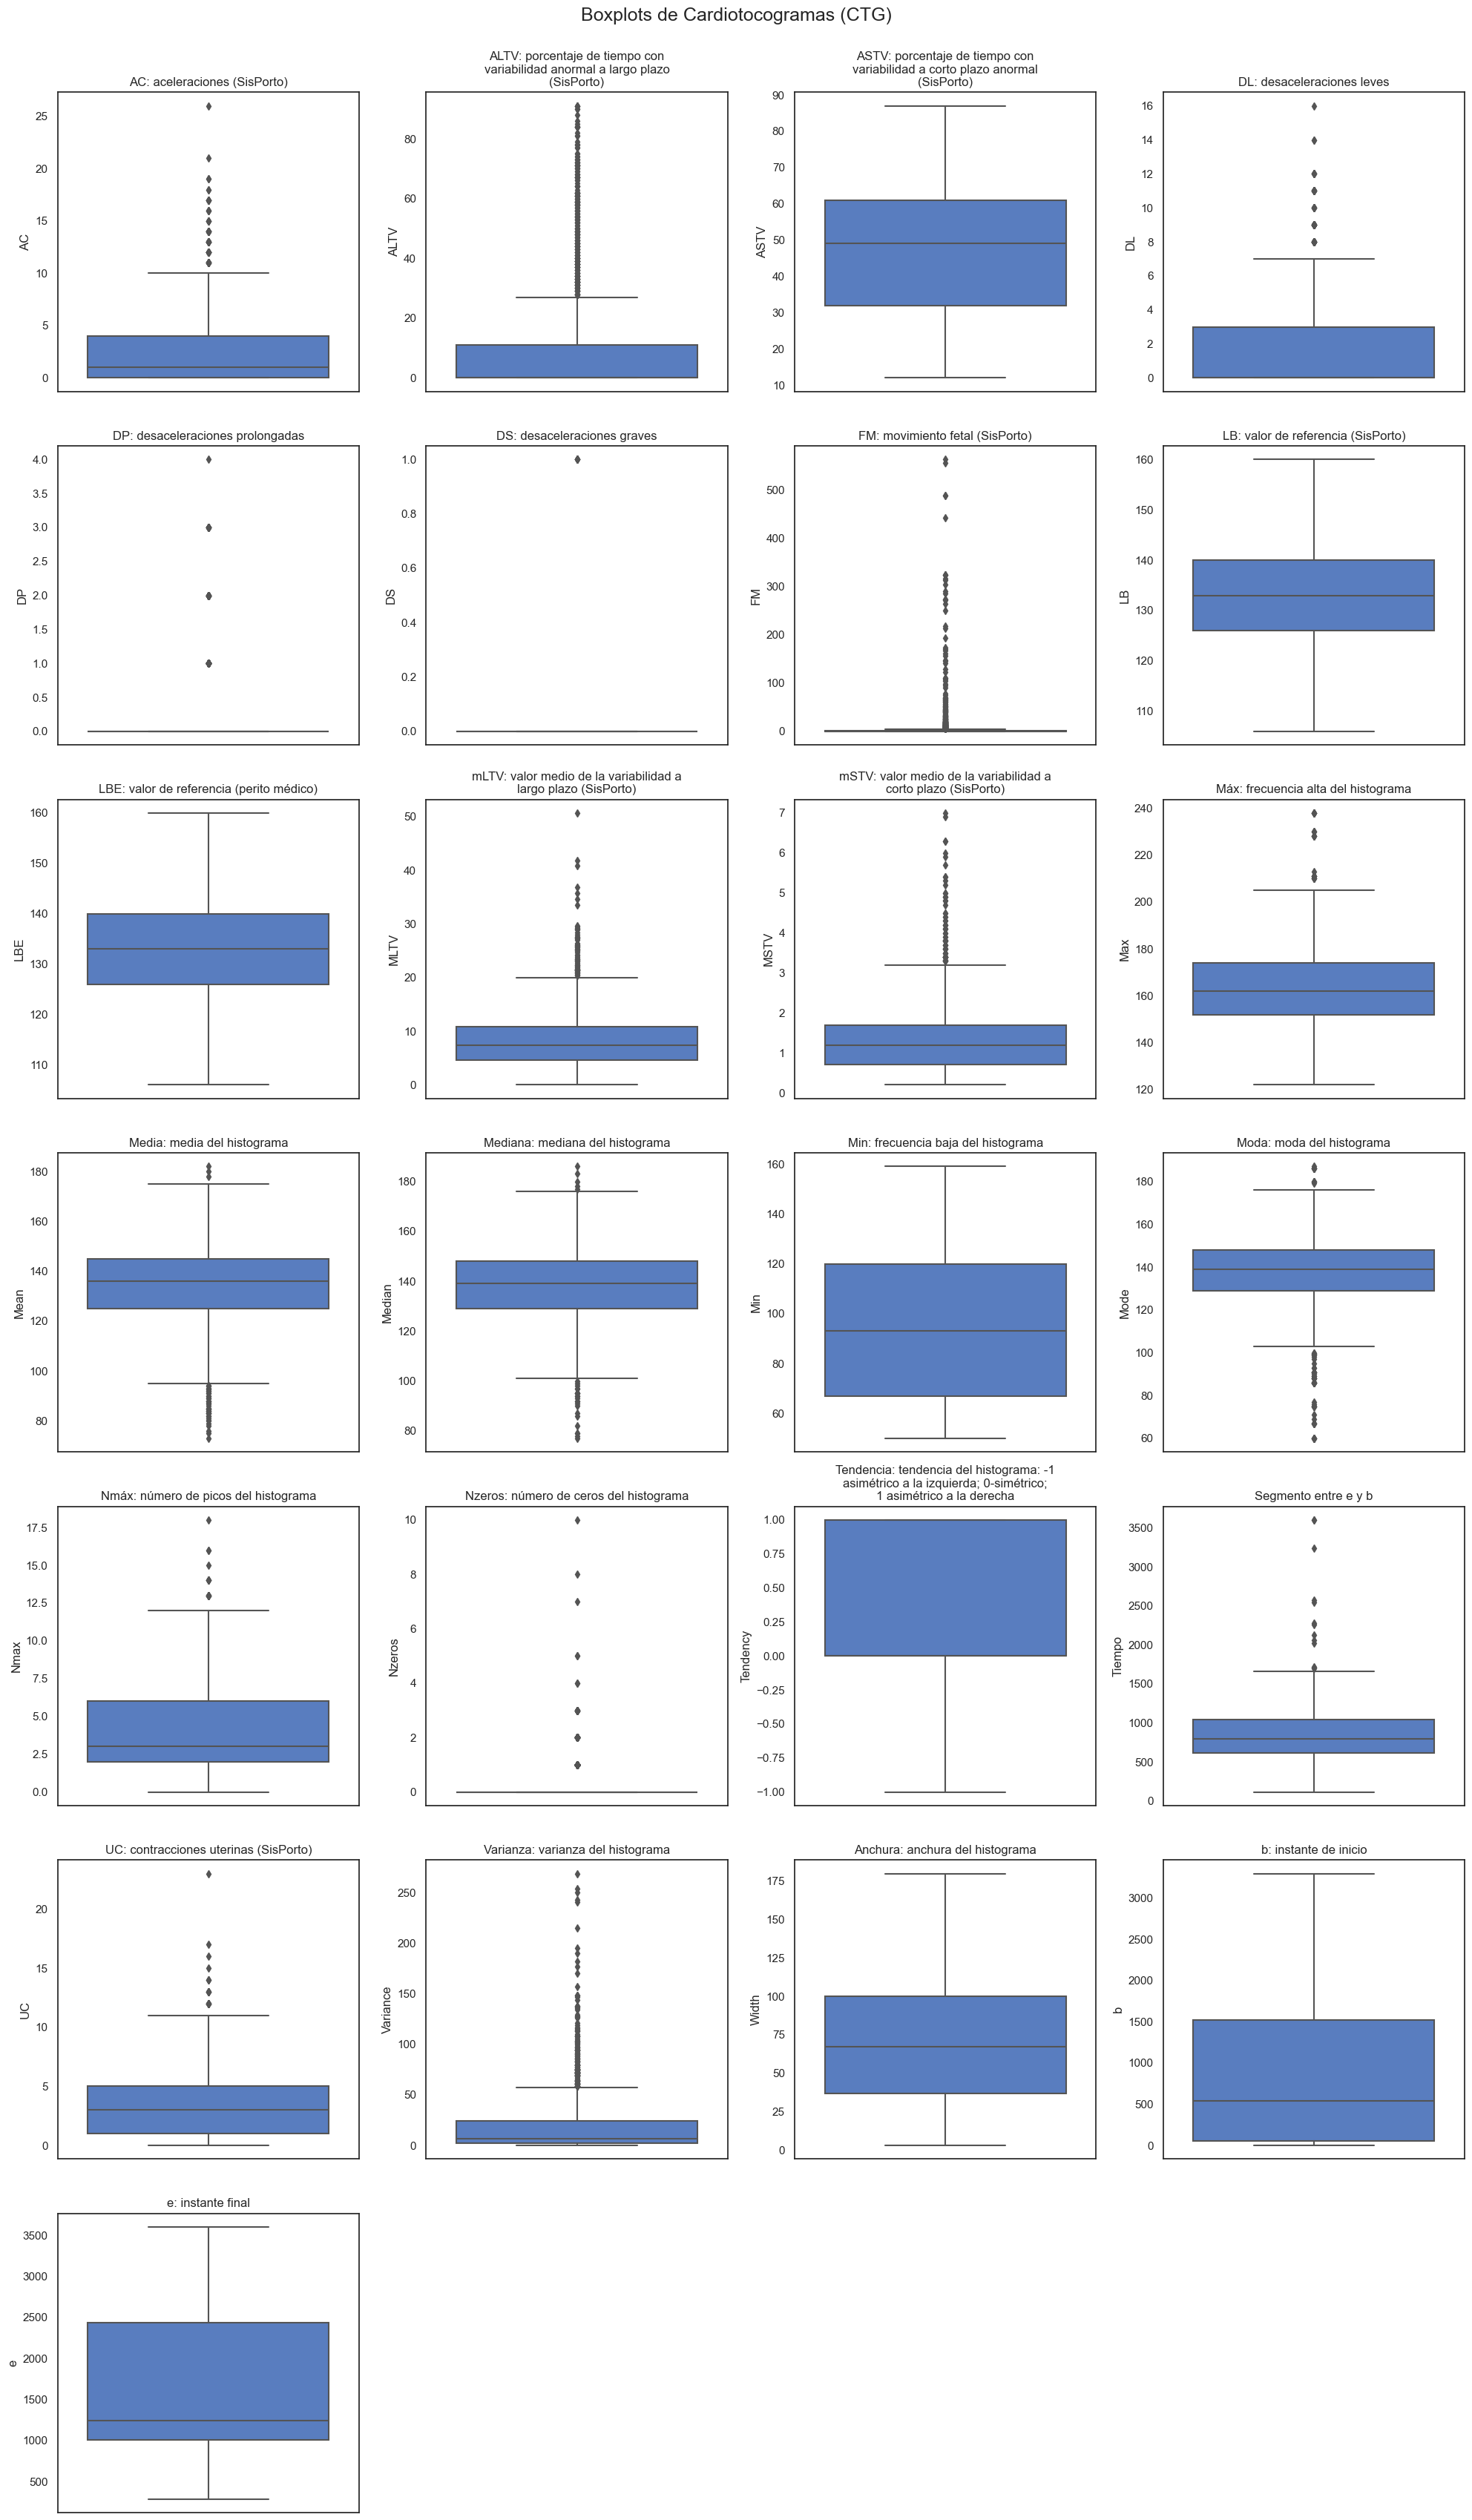

In [705]:
# Calcular el número de filas y columnas para el grid
num_cols = len(numeric_cols)
num_rows = (num_cols + 3) // 4  # Ajusta el número de columnas por fila según tu preferencia

# Crear el grid de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Aplanar el array de ejes para facilitar la iteración

# Crear boxplots para cada columna numérica
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    titulo = f"{descripciones.get(col, 'Descripción no encontrada')}"
    titulo = textwrap.fill(titulo, width=40)
    axes[i].set_title(titulo)

# Eliminar subplots vacíos si es necesario
if num_cols < len(axes):
    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

fig.suptitle("Boxplots de Cardiotocogramas (CTG)", fontsize=18)

plt.tight_layout(rect=[0, 0.01, 1, 0.98])
plt.show()

## Insights de los Boxplots de Cardiotocogramas (CTG)

El gráfico muestra boxplots para diversas variables numéricas de Cardiotocogramas (CTG). Los boxplots proporcionan información sobre la distribución de cada variable, incluyendo la mediana, los cuartiles, y los valores atípicos.

### Observaciones Generales

* **Distribución de Variables:** Los boxplots permiten visualizar la distribución de cada variable y detectar asimetrías o valores atípicos.
* **Valores Atípicos:** Se observan valores atípicos en muchas de las variables, lo que sugiere la presencia de registros inusuales o extremos en el conjunto de datos.
* **Escala de Variables:** Las variables tienen diferentes escalas, lo que dificulta la comparación directa de sus distribuciones.

### Insights por Variable

* **AC (Aceleraciones por segundo):**
    * Presencia de valores atípicos altos, lo que indica registros con un número inusualmente alto de aceleraciones.
    * Distribución asimétrica hacia la derecha.
* **ASTV (Porcentaje de tiempo con variabilidad a corto plazo anormal):**
    * Presencia de valores atípicos altos, lo que indica registros con una variabilidad a corto plazo anormalmente alta.
    * Distribución asimétrica hacia la derecha.
* **DL (Desaceleraciones leves):**
    * Presencia de valores atípicos altos, lo que indica registros con un número inusualmente alto de desaceleraciones leves.
    * Distribución asimétrica hacia la derecha.
* **DP (Desaceleraciones prolongadas):**
    * Presencia de valores atípicos altos, lo que indica registros con un número inusualmente alto de desaceleraciones prolongadas.
    * Distribución asimétrica hacia la derecha.
* **FM (Movimiento fetal):**
    * Presencia de valores atípicos altos, lo que indica registros con un número inusualmente alto de movimientos fetales.
    * Distribución asimétrica hacia la derecha.
* **LBE (Línea base):**
    * Distribución relativamente simétrica con algunos valores atípicos.
* **MLTV (Valor medio de la variabilidad a largo plazo):**
    * Presencia de valores atípicos altos, lo que indica registros con una variabilidad a largo plazo anormalmente alta.
    * Distribución asimétrica hacia la derecha.
* **MSTV (Valor medio de la variabilidad a corto plazo):**
    * Presencia de valores atípicos altos, lo que indica registros con una variabilidad a corto plazo anormalmente alta.
    * Distribución asimétrica hacia la derecha.
* **Nmax (Máximo del Histograma):**
    * Presencia de valores atípicos altos, lo que indica registros con un valor máximo del histograma inusualmente alto.
    * Distribución asimétrica hacia la derecha.
* **Nzeros (Número de ceros del Histograma):**
    * Presencia de valores atípicos altos, lo que indica registros con un número de ceros del histograma inusualmente alto.
    * Distribución asimétrica hacia la derecha.
* **Tendency (Tendencia):**
    * Distribución relativamente simétrica con algunos valores atípicos.
* **UC (Contracciones uterinas):**
    * Presencia de valores atípicos altos, lo que indica registros con un número inusualmente alto de contracciones uterinas.
    * Distribución asimétrica hacia la derecha.

c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


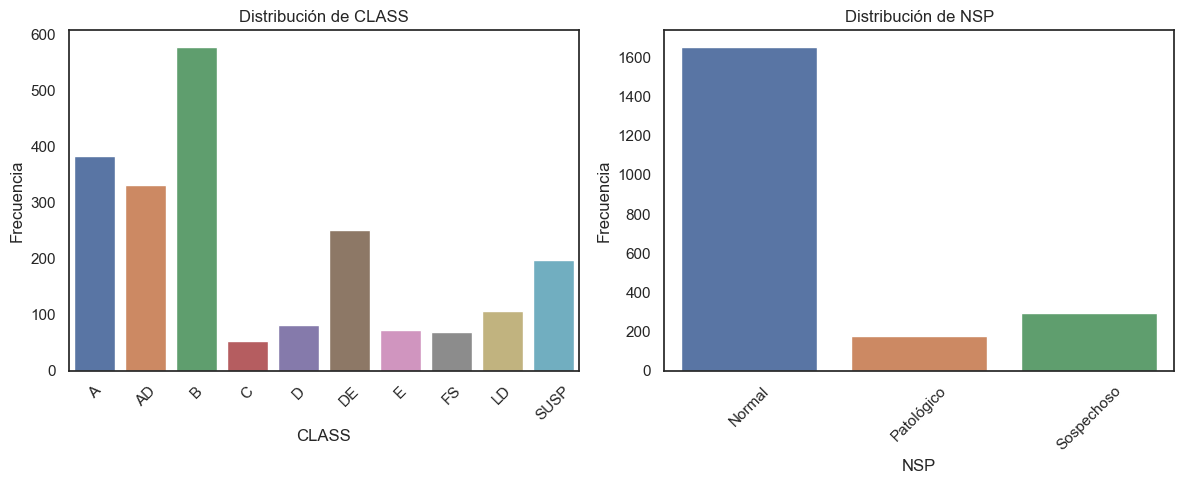

In [706]:
#Histogramas
# Configuración de la visualización
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(12, 5))  # Distribuir horizontalmente

# Generar histogramas para cada variable categórica
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, ax=axes[i], palette="deep")
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")
    axes[i].tick_params(axis='x', rotation=45)  # Rotar etiquetas para mejor legibilidad

plt.tight_layout()
plt.show()

## Insights del Gráfico: Distribución de Variables Categóricas

El gráfico muestra la distribución de dos variables categóricas: `CLASS` y `NSP`.

### Distribución de `CLASS`

* **Categorías:** La variable `CLASS` tiene varias categorías, incluyendo 'A', 'AD', 'B', 'C', 'D', 'DE', 'E', 'FS', 'LD', y 'SUSP'.
* **Frecuencia:**
    * La categoría 'B' tiene la frecuencia más alta, indicando que es la clase más común en el conjunto de datos.
    * Las categorías 'C', 'E', y 'LD' tienen las frecuencias más bajas, sugiriendo que son las clases menos comunes.
    * Las demás categorías muestran frecuencias intermedias.
* **Implicaciones:** La distribución desigual de las categorías en `CLASS` podría indicar un desbalance de clases, lo cual es importante considerar al entrenar modelos de clasificación.

### Distribución de `NSP`

* **Categorías:** La variable `NSP` tiene tres categorías: 'Normal', 'Patológico', y 'Sospechoso'.
* **Frecuencia:**
    * La categoría 'Normal' tiene una frecuencia significativamente más alta que las otras dos categorías.
    * La categoría 'Patológico' tiene la frecuencia más baja.
    * La categoría 'Sospechoso' tiene una frecuencia intermedia.
* **Implicaciones:**
    * La alta frecuencia de la categoría 'Normal' sugiere que la mayoría de los registros en el conjunto de datos corresponden a casos normales.
    * El desbalance entre las categorías de `NSP` es aún más pronunciado que en `CLASS`, lo cual también debe ser considerado al entrenar modelos.

### Observaciones Generales

* **Desbalance de Clases:** Ambas variables categóricas muestran un desbalance de clases, lo cual puede afectar el rendimiento de los modelos de aprendizaje automático.
* **Visualización:** Los gráficos de barras son efectivos para visualizar la distribución de variables categóricas y permiten identificar rápidamente las categorías más y menos frecuentes.
* **Consideraciones:** Al analizar estos datos, es importante tener en cuenta el contexto del problema y cómo el desbalance de clases podría influir en los resultados del análisis o modelado.

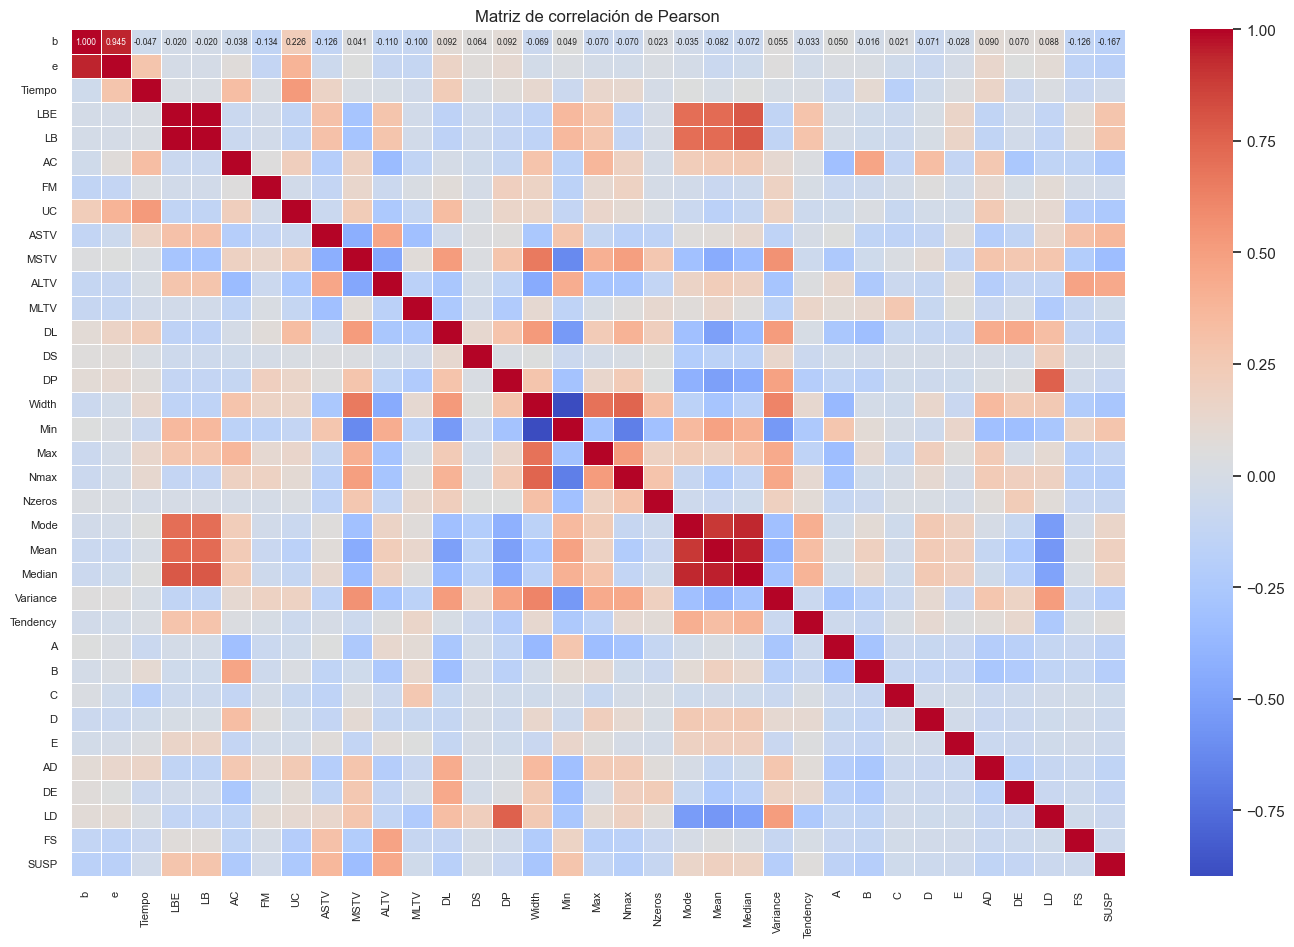

In [707]:
#Analisis de correlacion
sns.set(style="white", palette="muted")
# Calcular la matriz de correlación de Pearson
corr = df[numeric_cols_all].corr()

# Configurar la visualización
plt.figure(figsize=(17, 11))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5,
            annot_kws={"fontsize": 6}) 
plt.title("Matriz de correlación de Pearson", fontsize=8) 
plt.xticks(fontsize=8) 
plt.yticks(fontsize=8) 
plt.title("Matriz de correlación de Pearson")
plt.show()


## Insights de la Matriz de Correlación de Pearson

El gráfico muestra una matriz de correlación de Pearson entre las variables numéricas del conjunto de datos. Los valores de correlación varían de -1 a 1, donde:

* 1 indica una correlación positiva perfecta.
* -1 indica una correlación negativa perfecta.
* 0 indica que no hay correlación lineal.

### Observaciones Generales

* **Visualización:** El mapa de calor (heatmap) es una herramienta efectiva para visualizar la matriz de correlación, permitiendo identificar rápidamente las correlaciones fuertes y débiles.
* **Rango de Correlaciones:** La mayoría de las correlaciones parecen estar dentro del rango de -0.3 a 0.3, lo que sugiere que muchas de las variables no tienen una fuerte correlación lineal entre sí.
* **Correlaciones Fuertes:** Se pueden observar algunas correlaciones más fuertes (tanto positivas como negativas), que merecen una atención especial.

### Correlaciones Destacadas

* **LBE y LB:**
    * Se observa una correlación perfecta de 1.00 entre las variables 'LBE' y 'LB'. Esto indica que estas dos variables son idénticas o altamente redundantes.
* **Correlaciones entre variables de variabilidad:**
    * Se observa correlación entre las variables ASTV, MSTV, ALTV y MLTV. Esto es lógico, ya que todas miden la variabilidad de la frecuencia cardiaca fetal.
* **Correlaciones entre variables de histograma:**
    * Existe una alta correlación entre las variables de histograma. Esto es debido a que todas representan diferentes propiedades de la misma distribución de datos.
* **Correlaciones con DP (Desaceleraciones Prolongadas):**
    * La variable 'DP' muestra correlaciones negativas con varias otras variables, lo que sugiere que las desaceleraciones prolongadas están asociadas con cambios en otros parámetros del CTG.
* **Correlaciones con variables de tiempo:**
    * La variable tiempo muestra correlaciones bajas con el resto de variables.

### Implicaciones

* **Redundancia de Variables:** La correlación perfecta entre 'LBE' y 'LB' sugiere que una de estas variables podría ser redundante y podría eliminarse del conjunto de datos.
* **Relaciones Clínicas:** Las correlaciones observadas pueden proporcionar información valiosa sobre las relaciones clínicas entre las variables del CTG.
* **Selección de Características:** Al construir modelos de aprendizaje automático, es importante considerar las correlaciones entre las variables para evitar la multicolinealidad y mejorar el rendimiento del modelo.
* **Análisis Adicional:** Se recomienda realizar análisis adicionales, como pruebas de significancia estadística, para confirmar las correlaciones observadas y determinar su importancia clínica.

c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


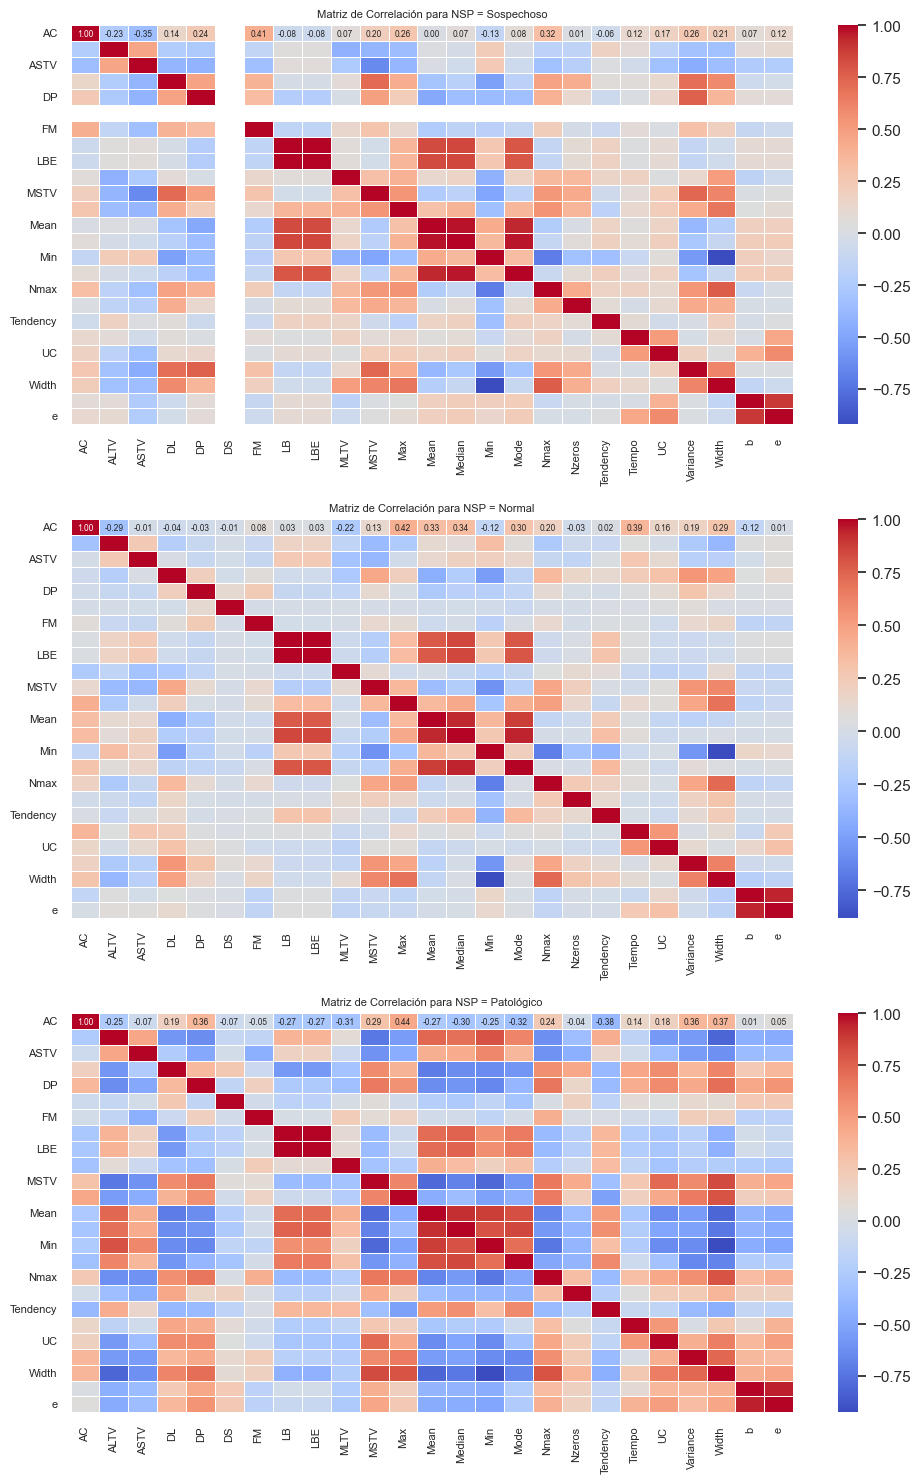

In [708]:
nsp_values = df['NSP'].unique()
sns.set(style="white", palette="muted")

# Crear el grid de subplots
fig, axes = plt.subplots(nrows=len(nsp_values), ncols=1, figsize=(10, 15))

# Crear heatmaps para cada valor de NSP
for i, nsp_val in enumerate(nsp_values):
    # Filtrar el DataFrame por el valor de NSP
    df_filtered = df[df['NSP'] == nsp_val]

    # Calcular la matriz de correlaciones para el subconjunto filtrado
    corr = df_filtered[numeric_cols].corr()

    # Crear el heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
                annot_kws={"fontsize": 6}, ax=axes[i])
    axes[i].set_title(f"Matriz de Correlación para NSP = {nsp_val}", fontsize=8)
    axes[i].tick_params(axis='x', labelsize=8) 
    axes[i].tick_params(axis='y', labelsize=8)


plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

## Insights de las Matrices de Correlación por Categoría de NSP

Los gráficos muestran las matrices de correlación de Pearson para tres categorías de `NSP`: Sospechoso, Normal y Patológico.

### Matriz de Correlación para NSP = Sospechoso

* **Correlaciones Fuertes Positivas:**
    * `LBE` y `LB` muestran una correlación perfecta de 1.00, lo que indica que son variables idénticas o altamente redundantes.
    * Se observan correlaciones positivas significativas entre variables relacionadas con la variabilidad de la frecuencia cardíaca fetal, como `ASTV`, `MLTV`, y otras variables de variabilidad.
* **Correlaciones Fuertes Negativas:**
    * `DP` (desaceleraciones prolongadas) muestra correlaciones negativas con varias otras variables, lo que sugiere que las desaceleraciones prolongadas están asociadas con cambios en otros parámetros del CTG.
* **Patrones Generales:**
    * Las variables relacionadas con el histograma muestran correlaciones significativas entre sí.
    * Las variables relacionadas con la variabilidad de la frecuencia cardíaca fetal también muestran correlaciones significativas entre sí.

### Matriz de Correlación para NSP = Normal

* **Correlaciones Fuertes Positivas:**
    * Al igual que en la categoría Sospechoso, `LBE` y `LB` muestran una correlación perfecta de 1.00.
    * Se observan correlaciones positivas significativas entre variables relacionadas con la variabilidad de la frecuencia cardíaca fetal.
* **Correlaciones Fuertes Negativas:**
    * Al igual que en la categoría Sospechoso, `DP` muestra correlaciones negativas con varias otras variables.
* **Patrones Generales:**
    * Los patrones de correlación son similares a los observados en la categoría Sospechoso, pero con algunas diferencias en la magnitud de las correlaciones.

### Matriz de Correlación para NSP = Patológico

* **Correlaciones Fuertes Positivas:**
    * Al igual que en las otras categorías, `LBE` y `LB` muestran una correlación perfecta de 1.00.
    * Se observan correlaciones positivas significativas entre variables relacionadas con la variabilidad de la frecuencia cardíaca fetal.
* **Correlaciones Fuertes Negativas:**
    * Al igual que en las otras categorías, `DP` muestra correlaciones negativas con varias otras variables.
* **Patrones Generales:**
    * Los patrones de correlación son similares a los observados en las otras categorías, pero con algunas diferencias en la magnitud de las correlaciones.


In [709]:
#removemos las columnas redudantes
numeric_cols_all=numeric_cols_all.drop('LBE', errors='ignore')
numeric_cols_all=numeric_cols_all.drop('b', errors='ignore')
numeric_cols_all=numeric_cols_all.drop('e', errors='ignore')

In [710]:
numeric_cols_all

Index(['Tiempo', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DS', 'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE',
       'LD', 'FS', 'SUSP'],
      dtype='object')

# 3-Detección de anomalías

In [711]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [712]:
# Escalar los datos numéricos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_cols_all])

contaminacion = 0.05
texto_normal = "Normal"
texto_anomalo = "Anómalo"

# 1. Isolation Forest
iso_forest = IsolationForest(contamination=contaminacion, random_state=33)
iso_forest_pred = iso_forest.fit_predict(df_scaled)

# 2. Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20,contamination=contaminacion)
lof_pred = lof.fit_predict(df_scaled)

# Agregar las predicciones al DataFrame original
df['iso_forest_anomaly'] = iso_forest_pred
df['lof_anomaly'] = lof_pred

df['iso_forest_anomaly'] = df['iso_forest_anomaly'].apply(lambda x: texto_anomalo if x == -1 else texto_normal)
df['lof_anomaly'] = df['lof_anomaly'].apply(lambda x: texto_anomalo if x == -1 else texto_normal)

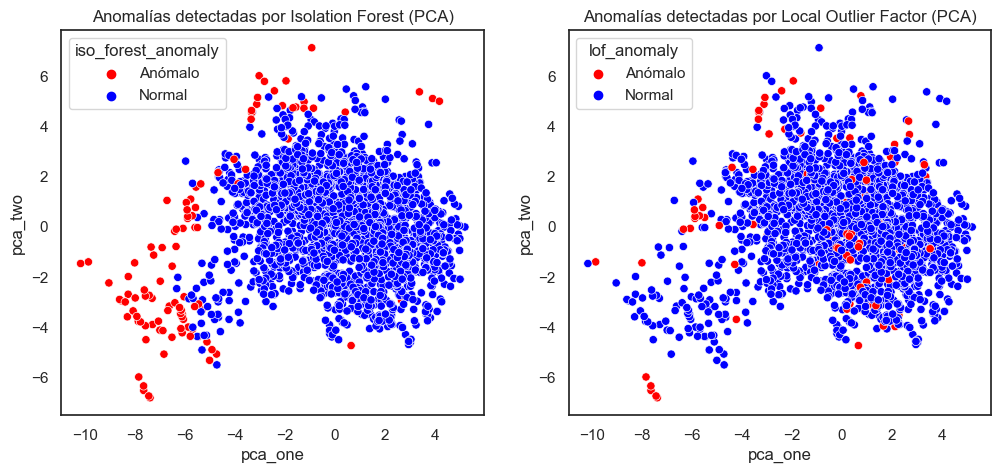

In [713]:
# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df['pca_one'] = pca_result[:, 0]
df['pca_two'] = pca_result[:, 1]

# Gráfico de dispersión para Isolation Forest con PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
color_map = {'Normal': 'blue', 'Anómalo': 'red'}
sns.scatterplot(x='pca_one', y='pca_two', hue='iso_forest_anomaly', data=df, palette=color_map)
plt.title('Anomalías detectadas por Isolation Forest (PCA)')

# Gráfico de dispersión para Local Outlier Factor con PCA
plt.subplot(1, 2, 2)
sns.scatterplot(x='pca_one', y='pca_two', hue='lof_anomaly', data=df, palette=color_map)
plt.title('Anomalías detectadas por Local Outlier Factor (PCA)')

plt.show()

- Isolation Forest tiende a identificar anomalías que se encuentran más alejadas del grupo principal de datos. En el gráfico de la izquierda, se observa que las anomalías (puntos rojos) se concentran principalmente en los bordes y fuera del grupo denso de puntos azules. Esto sugiere que Isolation Forest es eficaz para detectar anomalías globales, es decir, puntos que son significativamente diferentes del resto del conjunto de datos.
- LOF identifica anomalías que tienen una densidad local significativamente menor que sus vecinos.
En el gráfico de la derecha, se observa que LOF detecta anomalías tanto en los bordes como dentro del grupo principal de datos.
Esto sugiere que LOF es capaz de detectar tanto anomalías globales como locales, es decir, puntos que son anómalos en su región pero no necesariamente en todo el conjunto de datos.

In [714]:
def set_ax(fig, pos, metodo, title):
    ax1 = fig.add_subplot(pos, projection='3d')
    for label, color in nsp_colors.items():
        subset = df[df['NSP'] == label]
        ax1.scatter(subset['PC1'], subset['PC2'], subset['PC3'], c=color, label=label, alpha=0.6)
    # Marcar anomalías con X
    anomalies = df[df[metodo] == texto_anomalo]

    ax1.scatter(anomalies['PC1'], anomalies['PC2'], anomalies['PC3'], c='black', marker='x', label=texto_anomalo, s=80)
    ax1.set_title(title)
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3", rotation=90)
    ax1.legend()

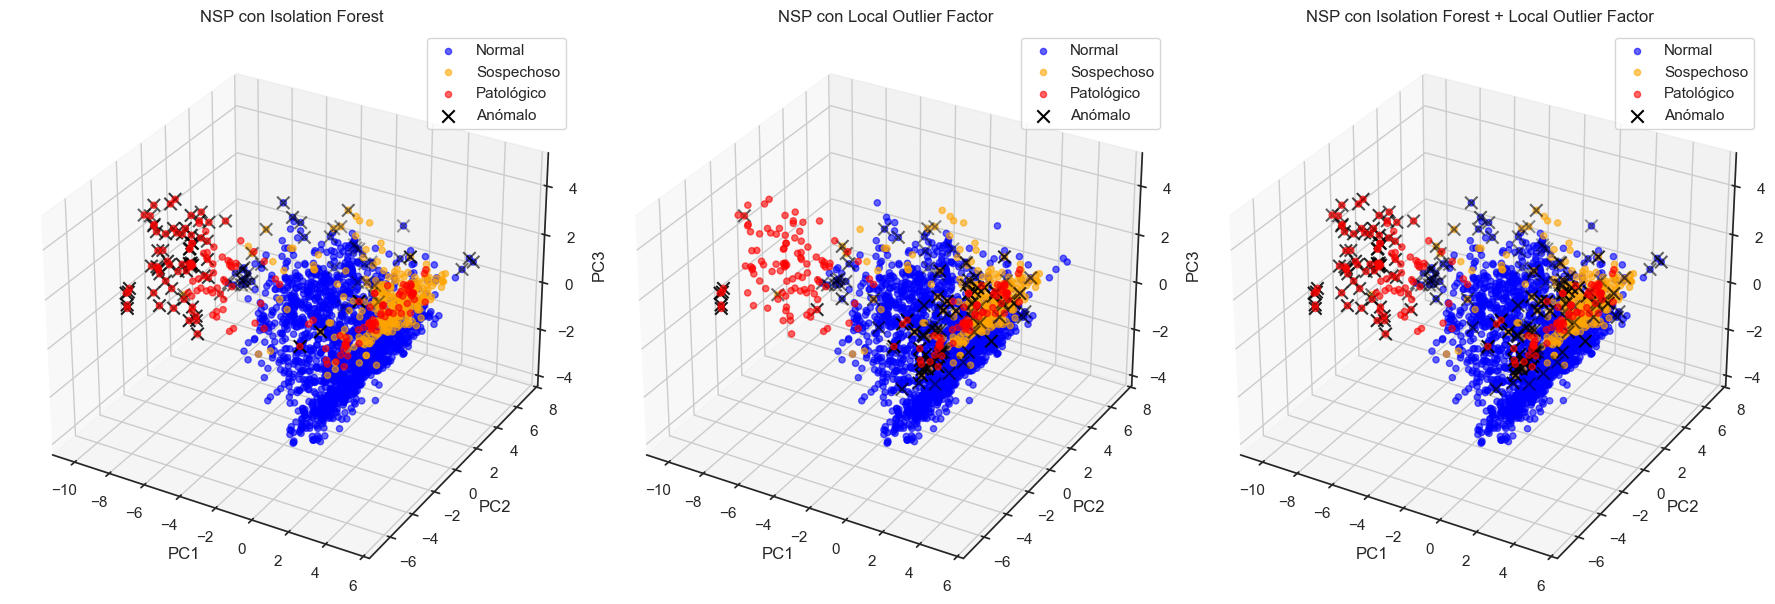

In [715]:
# Aplicar PCA para reducir la dimensionalidad a 3 componentes
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# Agregar los componentes principales al DataFrame
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]
df['PC3'] = pca_result[:, 2]

df['Anomalia_Combo'] = df.apply(lambda x: texto_anomalo if x['iso_forest_anomaly'] == texto_anomalo or x['lof_anomaly'] == texto_anomalo else texto_normal, axis=1)

# Crear gráficos 3D para cada combinación
fig = plt.figure(figsize=(18, 6))


# Definir colores para cada categoría de NSP
nsp_colors = {'Normal': 'blue', 'Sospechoso': 'orange', 'Patológico': 'red'}

# Gráfico 1: NSP con IF (X para anomalías)
set_ax(fig,131,'iso_forest_anomaly',title="NSP con Isolation Forest")
set_ax(fig,132,'lof_anomaly',title="NSP con Local Outlier Factor")
set_ax(fig,133,'Anomalia_Combo',title="NSP con Isolation Forest + Local Outlier Factor")


plt.tight_layout()
plt.show()

- Isolation Forest detecta valores atípicos extremos, útil para identificar fetos en alto riesgo con métricas fisiológicas fuera del rango normal.
- LOF es más flexible y detecta patrones anómalos en densidades locales, ayudando a encontrar casos de riesgo moderado que podrían ser ignorados por IF.
- La combinación de ambos métodos permite una detección más completa de anomalías, asegurando que tanto casos críticos como sutiles sean identificados.

# 4-Análisis de Clusters

In [716]:
#funcion para graficar los clusters
def plot_clusters(fig, pos, cluster_col, title):
    ax = fig.add_subplot(pos, projection='3d')
    clusters = sorted(df[cluster_col].unique())
    colors = sns.color_palette("bright", as_cmap=True)
    for cluster in clusters:
        subset = df[df[cluster_col] == cluster]
        ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], label=cluster, alpha=0.6, color=colors[cluster])
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3", rotation=90)
    ax.legend()


In [717]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [718]:
pca_cols = ['PC1', 'PC2', 'PC3']
ms = 20
# Aplicar DBSCAN sobre las componentes principales de PCA
dbscan = DBSCAN(eps=1, min_samples=ms-10)
df['Cluster_DBSCAN'] = dbscan.fit_predict(df[pca_cols])

# Aplicar DBSCAN sobre todas las columnas numéricas escaladas
dbscan = DBSCAN(eps=4.0, min_samples=ms+30)
df["Cluster_DBSCAN_All"] = dbscan.fit_predict(df_scaled)

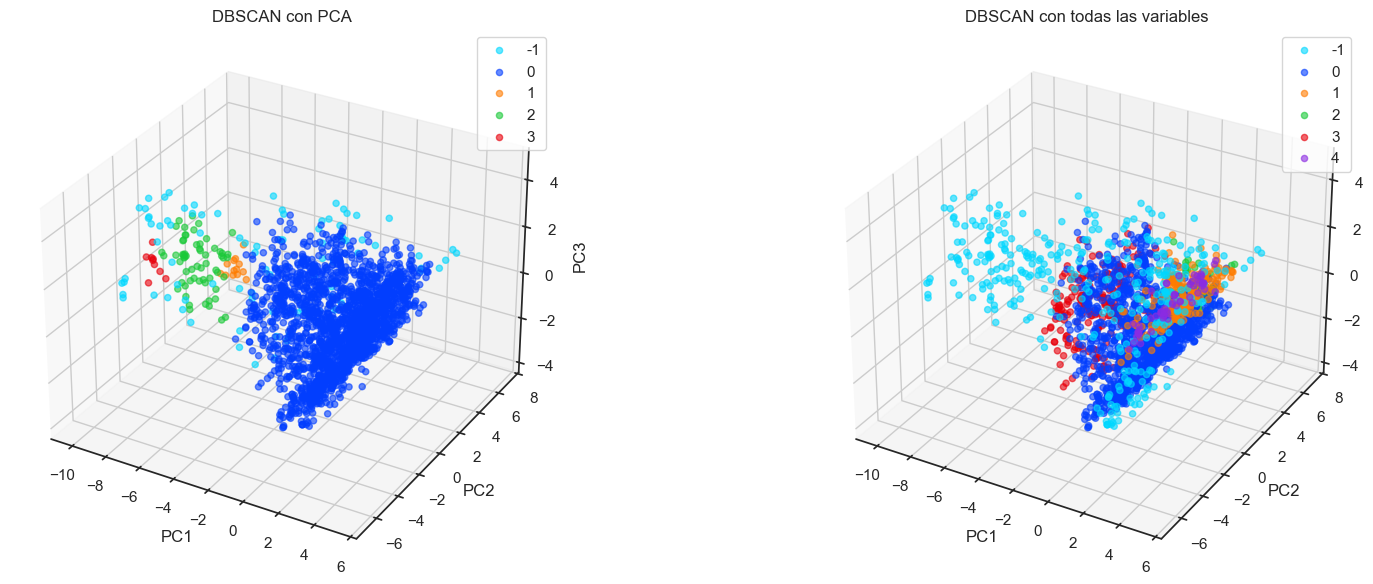

In [719]:
# Crear gráficos 3D para cada combinación
fig = plt.figure(figsize=(18, 6))

plot_clusters(fig,121,'Cluster_DBSCAN',title="DBSCAN con PCA")
plot_clusters(fig,122,'Cluster_DBSCAN_All',title="DBSCAN con todas las variables")
plt.tight_layout()
plt.show()

In [720]:
#crear una funcion analisis de codo para determinar el numero de clusters
def elbow_analysis(data, max_clusters=10, title='Elbow Analysis'):
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=33)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    #plot elbow analysis
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMe

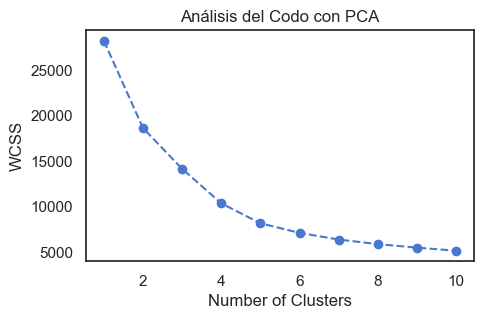

c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMe

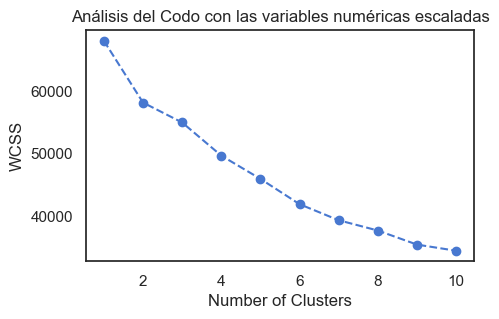

In [721]:
elbow_analysis(df[pca_cols], 10, "Análisis del Codo con PCA")
elbow_analysis(df_scaled, 10, "Análisis del Codo con las variables numéricas escaladas")

## Análisis del Codo: Determinación del Número Óptimo de Clusters (k=3)

Este análisis del codo se realizó utilizando dos conjuntos de datos: uno con variables numéricas escaladas y otro con los componentes principales (PCA). El objetivo es determinar el número óptimo de clusters (k) para aplicar el algoritmo K-Means.

### Observaciones Generales

* **Eje X:** Representa el número de clusters considerados, variando de 1 a 10 en ambos análisis.
* **Eje Y:** Muestra el WCSS (Within-Cluster Sum of Squares), que mide la suma de las distancias al cuadrado entre cada miembro de un cluster y su centroide.
* **Disminución de WCSS:** En ambos análisis, se observa una disminución del WCSS a medida que aumenta el número de clusters.
* **Punto de Codo:** El punto de codo, donde la disminución del WCSS comienza a ralentizarse, se identifica claramente en **k = 3** en ambos gráficos.

### Análisis con Variables Numéricas Escalas

* **Punto de Codo:** El punto de codo se identifica claramente en **k = 3**.
* **Interpretación:** Antes de k = 3, la disminución del WCSS es pronunciada, lo que indica que agregar más clusters mejora significativamente la compactación de los clusters. Después de k = 3, la disminución del WCSS es mucho más gradual, lo que indica que agregar más clusters proporciona una mejora marginal en la compactación de los clusters.

### Análisis con PCA

* **Punto de Codo:** El punto de codo también se identifica claramente en **k = 3**.
* **Interpretación:** Al igual que con las variables numéricas escaladas, antes de k = 3, la disminución del WCSS es pronunciada, y después de k = 3, la disminución es gradual.

### Conclusión

En ambos análisis, tanto con variables numéricas escaladas como con PCA, el análisis del codo indica que el número óptimo de clusters para este conjunto de datos es **k = 3**. Esto sugiere que los datos se pueden segmentar de manera efectiva en tres grupos distintos, independientemente de si se utilizan las variables numéricas escaladas o los componentes principales obtenidos por PCA.

In [755]:
k=3
mi=300
ni=20
# Aplicar KMeans sobre las componentes principales de PCA
dbscan = KMeans(n_clusters=k,n_init=ni, max_iter=mi, random_state=33)
df['Cluster_KMeans'] = dbscan.fit_predict(df[['PC1', 'PC2', 'PC3']])

# Aplicar KMeans sobre todas las columnas numéricas escaladas
dbscan = KMeans(n_clusters=k,n_init=ni,max_iter=mi,  random_state=33)
df["Cluster_KMeans_All"] = dbscan.fit_predict(df_scaled)

c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


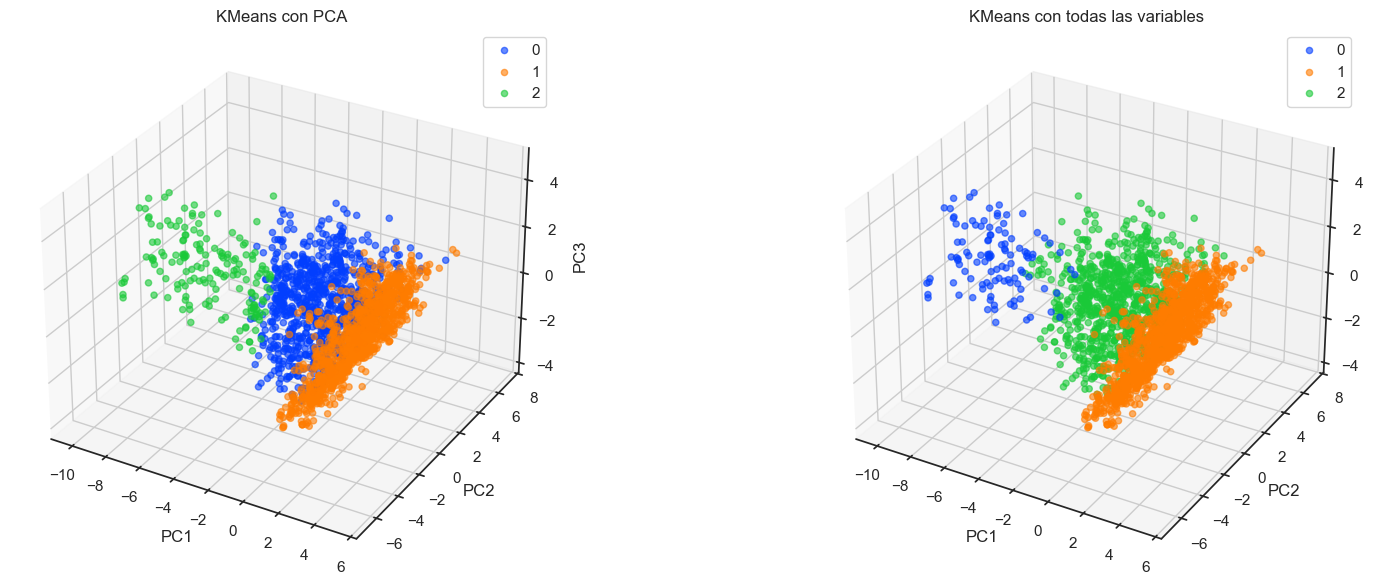

In [749]:
# Crear gráficos 3D para cada combinación
fig = plt.figure(figsize=(18, 6))

plot_clusters(fig,121,'Cluster_KMeans',title="KMeans con PCA")
plot_clusters(fig,122,'Cluster_KMeans_All',title="KMeans con todas las variables")
plt.tight_layout()
plt.show()

In [724]:
#set ax para graficar los clusters por NSP en barras apiladas cluster en las x, proporcion en y
def set_ax_cluster(fig, pos, cluster_col, title, loc_legend='upper right'):
    ax = fig.add_subplot(pos)
    crosstab = pd.crosstab(df[cluster_col], df['NSP'])
    crosstab.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Proporción")
    ax.legend(title='NSP', loc=loc_legend)




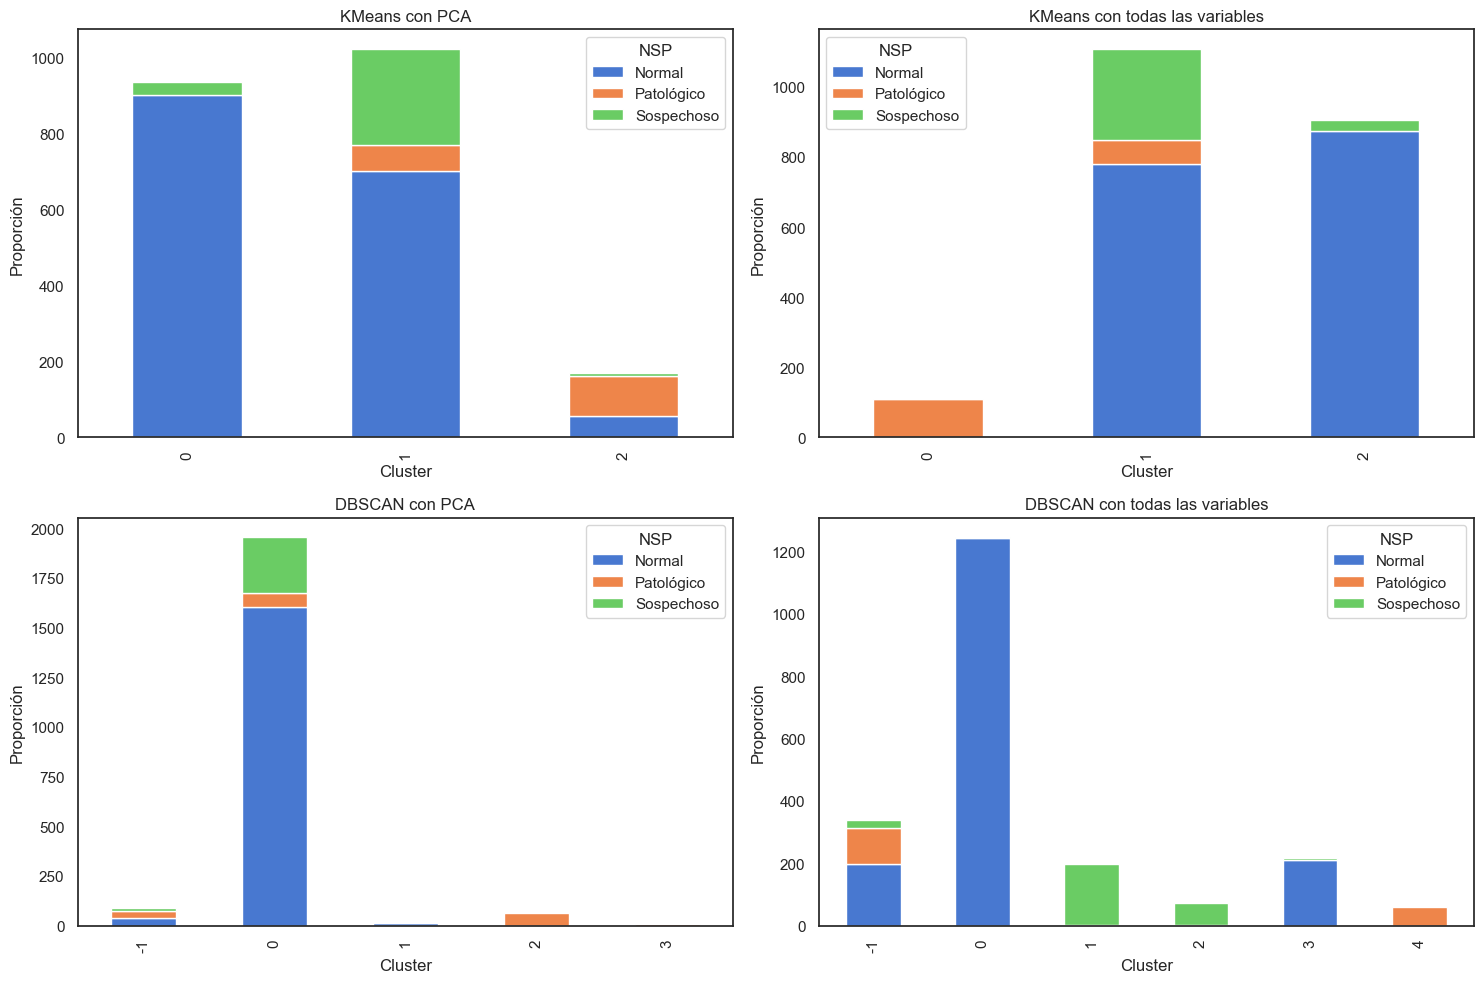

In [757]:
fig = plt.figure(figsize=(15, 10))
set_ax_cluster(fig,221,'Cluster_KMeans',title="KMeans con PCA",loc_legend='upper right')
set_ax_cluster(fig,222,'Cluster_KMeans_All',title="KMeans con todas las variables",loc_legend='upper left')
set_ax_cluster(fig,223,'Cluster_DBSCAN',title="DBSCAN con PCA")
set_ax_cluster(fig,224,'Cluster_DBSCAN_All',title="DBSCAN con todas las variables")
plt.tight_layout()
plt.show()

## Comparación de Métodos de Clustering

| Método | Ventajas | Desventajas | Mejor Modelo General |
|---|---|---|---|
| **KMeans con PCA** | - Simple y fácil de interpretar. <br> - Útil para obtener una visión general rápida. <br> - Clusters con proporciones relativamente equilibradas. | - Segmentación general, no específica por categoría de NSP. <br> - Pérdida de información debido a la reducción de dimensionalidad. | - Útil para obtener una visión general rápida de los grupos principales en los datos. |
| **KMeans con Todas las Variables** | - Segmentación más específica por categoría de NSP. <br> - Útil para análisis más detallados. | - Más complejo que con PCA, pero aún interpretable. <br> - Proporciones de clusters menos equilibradas. | - Útil para análisis más detallados y segmentación específica. |
| **DBSCAN con PCA** | - Identifica valores atípicos. <br> - Clusters específicos por categoría de NSP. | - Más complejo debido a la identificación de valores atípicos. <br> - Requiere interpretación cuidadosa de clusters pequeños. <br> - Proporciones de clusters muy bajas en algunos casos. | - Útil para identificar valores atípicos y patrones específicos, pero con clusters pequeños. |
| **DBSCAN con Todas las Variables** | - Identifica valores atípicos. <br> - Segmentación más específica y granular por categoría de NSP. <br> - Proporciona la mayor granularidad en la segmentación. | - Más complejo debido a la identificación de valores atípicos y clusters pequeños. <br> - Proporciones de clusters bajas en algunos casos. | - **El mejor método general para una segmentación detallada y específica, identificando valores atípicos y clusters distintivos para cada categoría de NSP.** |

## Conclusiones

* **KMeans con PCA:** Proporciona una segmentación general, útil para obtener una visión rápida de los grupos principales en los datos.
* **KMeans con todas las variables:** Ofrece una segmentación más detallada y específica, útil para análisis más profundos.
* **DBSCAN con PCA y DBSCAN con todas las variables:** Ambos son efectivos para identificar valores atípicos y crear clusters específicos para cada categoría de NSP. DBSCAN con todas las variables proporciona la mayor granularidad en la segmentación, pero también genera clusters más pequeños que pueden ser difíciles de interpretar si no se tiene suficiente contexto.

**Mejor Modelo General:** **DBSCAN con todas las variables** se destaca como el mejor modelo general para este conjunto de datos debido a su capacidad para proporcionar una segmentación detallada y específica, identificar valores atípicos y crear clusters distintivos para cada categoría de NSP. Aunque genera clusters más pequeños, estos pueden ser valiosos para un análisis más profundo y específico de los datos.